## POS tagging using modified Viterbi

### Problem Statement - HMMs and Viterbi algorithm for POS tagging
You have learnt to build your own HMM-based POS tagger and implement the Viterbi algorithm using the Penn Treebank training corpus. The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

Need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques.

### Goals
Split the Treebank dataset into train and validation sets. Please use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.

 
Need to accomplish the following in this assignment:

<li>Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) </li>
<li>Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.</li>
<li>Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.</li>
<li>List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.</li>

### Data Preparation

In [71]:
#Importing libraries
import nltk
# nltk.download('universal_tagset') // Run in case when universal_tagset not found
import random
from sklearn.model_selection import train_test_split
import pprint, time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

In [4]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [11]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Preliminary', 'ADJ'), ('tallies', 'NOUN'), ('by', 'ADP'), ('the', 'DET'), ('Trade', 'NOUN'), ('and', 'CONJ'), ('Industry', 'NOUN'), ('Ministry', 'NOUN'), ('showed', 'VERB'), ('another', 'DET'), ('trade', 'NOUN'), ('deficit', 'NOUN'), ('in', 'ADP'), ('October', 'NOUN'), (',', '.'), ('the', 'DET'), ('fifth', 'ADJ'), ('monthly', 'ADJ'), ('setback', 'NOUN'), ('this', 'DET'), ('year', 'NOUN'), (',', '.'), ('*', 'X'), ('casting', 'VERB'), ('a', 'DET'), ('cloud', 'NOUN'), ('on', 'ADP'), ('South', 'NOUN'), ('Korea', 'NOUN'), ("'s", 'PRT'), ('export-oriented', 'ADJ'), ('economy', 'NOUN'), ('.', '.')], [('Meanwhile', 'ADV'), (',', '.'), ('the', 'DET'), ('bad', 'ADJ'), ('bank', 'NOUN'), ('with', 'ADP'), ('the', 'DET'), ('junk', 'NOUN'), ('bonds', 'NOUN'), ('--', '.'), ('and', 'CONJ'), ('some', 'DET'), ('capital', 'NOUN'), ('--', '.'), ('might', 'VERB'), ('be', 'VERB'), ('spun', 'VERB'), ('off', 'PRT'), ('*-1', 'X'), ('to', 'PRT'), ('Columbia', 'NOUN'), ('shareholders', 'NOUN'), (',',

In [12]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95375

In [50]:
# tokens in the train set - train_tagged_words
train_data_tokens = [pair[0] for pair in train_tagged_words]
train_data_tokens[:10]

['Preliminary',
 'tallies',
 'by',
 'the',
 'Trade',
 'and',
 'Industry',
 'Ministry',
 'showed',
 'another']

In [51]:
# POS tags for the tokens in the train set -

train_data_pos_tags = [pair[1] for pair in train_tagged_words]
train_data_pos_tags[:10]

['ADJ', 'NOUN', 'ADP', 'DET', 'NOUN', 'CONJ', 'NOUN', 'NOUN', 'VERB', 'DET']

In [52]:
# building the train vocabulary to a set

training_vocabulary_set = set(train_data_tokens)

In [53]:
# building the POS tags to a set

training_pos_tag_set = set(train_data_pos_tags)

### Emission Probabilities

In [28]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [24]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [19]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [25]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [26]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

### Exploratory Data Analysis

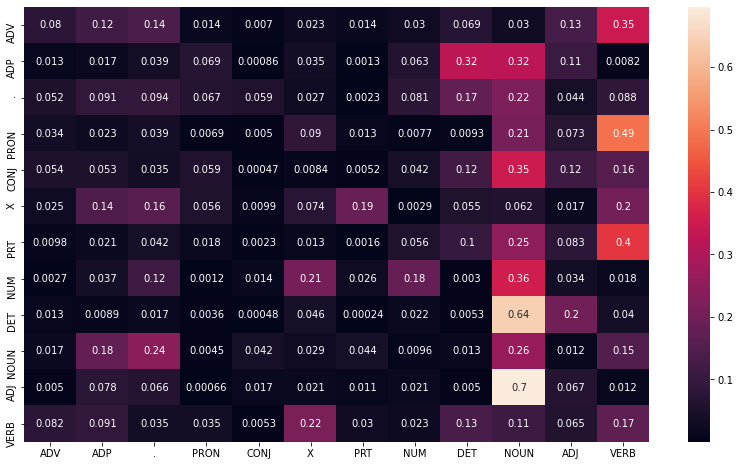

In [46]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [13]:
#calculate the length of tagged train words
len(train_tagged_words)

95375

In [14]:
# Viterbi Heuristic pos tagger
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Solve the problem of unknown words

In [39]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
# rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
# test_run = [test_set[i] for i in rndom]

# list of tagged words on whole test data set
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
test_run

[[('When', 'ADV'),
  ('it', 'PRON'),
  ("'s", 'VERB'),
  ('time', 'NOUN'),
  ('for', 'ADP'),
  ('their', 'PRON'),
  ('biannual', 'ADJ'),
  ('powwow', 'NOUN'),
  ('*T*-1', 'X'),
  (',', '.'),
  ('the', 'DET'),
  ('nation', 'NOUN'),
  ("'s", 'PRT'),
  ('manufacturing', 'VERB'),
  ('titans', 'NOUN'),
  ('typically', 'ADV'),
  ('jet', 'VERB'),
  ('off', 'PRT'),
  ('to', 'PRT'),
  ('the', 'DET'),
  ('sunny', 'ADJ'),
  ('confines', 'NOUN'),
  ('of', 'ADP'),
  ('resort', 'NOUN'),
  ('towns', 'NOUN'),
  ('like', 'ADP'),
  ('Boca', 'NOUN'),
  ('Raton', 'NOUN'),
  ('and', 'CONJ'),
  ('Hot', 'NOUN'),
  ('Springs', 'NOUN'),
  ('.', '.')],
 [('Officials', 'NOUN'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('various', 'ADJ'),
  ('banks', 'NOUN'),
  ('involved', 'VERB'),
  ('*', 'X'),
  ('are', 'VERB'),
  ('expected', 'VERB'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('meet', 'VERB'),
  ('during', 'ADP'),
  ('the', 'DET'),
  ('next', 'ADJ'),
  ('few', 'ADJ'),
  ('days', 'NOUN'),
  ('*-2', 'X'),
  ('to', 'PRT'

In [40]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [41]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  1963.4683039188385
[('The', 'DET'), ('yield', 'NOUN'), ('fell', 'VERB'), ('to', 'PRT'), ('7.88', 'NUM'), ('%', 'NOUN'), ('.', '.'), ('They', 'PRON'), ('also', 'ADV'), ('said', 'VERB'), ('that', 'ADP'), ('vendors', 'ADV'), ('were', 'VERB'), ('delivering', 'ADV'), ('goods', 'NOUN'), ('more', 'ADV'), ('quickly', 'ADV'), ('*ICH*-1', 'X'), ('in', 'ADP'), ('October', 'NOUN'), ('than', 'ADP'), ('they', 'PRON'), ('had', 'VERB'), ('*?*', 'X'), ('for', 'ADP'), ('each', 'DET'), ('of', 'ADP'), ('the', 'DET'), ('five', 'NUM'), ('previous', 'ADJ'), ('months', 'NOUN'), ('.', '.'), ('I', 'PRON'), ('would', 'VERB'), ('predict', 'VERB'), ('that', 'ADP'), ('within', 'ADP'), ('a', 'DET'), ('short', 'ADJ'), ('time', 'NOUN'), ('most', 'ADV'), ('of', 'ADP'), ('them', 'PRON'), ('would', 'VERB'), ('find', 'VERB'), ('Thunderbird', 'ADV'), ('a', 'DET'), ('satisfactory', 'ADJ'), ('substitute', 'ADV'), ('for', 'ADP'), ('Chivas', 'ADV'), ('Regal', 'ADV'), ('and', 'CONJ'), ('that', 'DET'), ('

#### Evaluating tagging accuracy

In [42]:
# check the accuracy of test data
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [43]:
#get the accuracy
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9028485191473307


In [47]:
#lets check the incorrect tags
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(incorrect_tagged_cases)

[[('that', 'ADP'), (('vendors', 'ADV'), ('vendors', 'NOUN'))], [('were', 'VERB'), (('delivering', 'ADV'), ('delivering', 'VERB'))], [('time', 'NOUN'), (('most', 'ADV'), ('most', 'ADJ'))], [('find', 'VERB'), (('Thunderbird', 'ADV'), ('Thunderbird', 'NOUN'))], [('satisfactory', 'ADJ'), (('substitute', 'ADV'), ('substitute', 'NOUN'))], [('for', 'ADP'), (('Chivas', 'ADV'), ('Chivas', 'NOUN'))], [('Chivas', 'NOUN'), (('Regal', 'ADV'), ('Regal', 'NOUN'))], [('and', 'CONJ'), (('that', 'DET'), ('that', 'ADP'))], [("''", '.'), (('phobias', 'ADV'), ('phobias', 'NOUN'))], [(',', '.'), (('depressions', 'ADV'), ('depressions', 'NOUN'))], [('like', 'ADP'), (('Grgich', 'ADV'), ('Grgich', 'NOUN'))], [('Hills', 'NOUN'), (('Chardonnay', 'ADV'), ('Chardonnay', 'NOUN'))], [('slow', 'VERB'), (('down', 'ADV'), ('down', 'PRT'))], [('high-priced', 'ADJ'), (('red', 'NOUN'), ('red', 'ADJ'))], [('and', 'CONJ'), (('Chardonnays', 'ADV'), ('Chardonnays', 'NOUN'))], [('*U*', 'X'), (('range', 'VERB'), ('range', 'NOUN

In [48]:
#get the length of incorrect tags
print(len(incorrect_tagged_cases))

515


#### Find those words present in train set but not in test set

In [54]:
#unknown words
test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("Unknown Words :", unknown_words)

Total Unknown words : 366
Unknown Words : ['upward', '8.56', 'Egyptian', 'appropriate', '*-113', 'Boorse', 'shuttle', 'spectrum', 'Bonnell', 'Mo', 'Doak', 'Review', 'heebie-jeebies', 'Employment', 'Woolworth', 'Assistant', 'bulls', 'Si', 'draws', 'secede', '*T*-139', 'near-limit', 'Chardonnay', 'Nissho-Iwai', 'federally', 'pre-approved', 'seduce', 'Scotland', 'small-time', '*T*-239', 'crusade', 'Reddington', 'Home', 'Pharaoh', 'depression', 'undo', 'roadblock', 'length', 'defined', 'cleanliness', 'bitterness', 'Watanabe', 'unimpeded', 'proscribes', 'viewing', 'PAP', 'Clemens', 'denominator', 'Legal', 'leapt', 'breaking', 'arrangements', 'Sept.30', 'lore', 'rang', 'acknowledges', 'adequate', 'Opportunity', '1.4', 'aboard', 'Arlington', 'Bricklayers', '38.3', 'Gingl', 'screwed', 'Mattress', 'consequence', 'sunny', 'Carbide', 'Cougar', 'bloods', 'Certainly', 'swaps', 'Anderson', 'Mercedes', 'printing-press', 'betrayer', 'phobias', '94.2', 'contest', 'Trailer', '0.50', 'intriguing', 'bankr

## Method 1-  To solve the problem of unknown words
The default Vanilla viterbi algorithm achieved an accuracy of about 90.7%. This approx. 9% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

Now lets see how we can minimize this loss by modifying the vanilla viterbi.

If a word is not present in the training vocabulary (unknown word), its emission probability will be ZERO. In that case the state probability will inturn be zero. Thus in cases where the algorithm encounters a word which it has not see previously, we can omit the emission probability and only consider the transition probability.

The algorithm can be modified to deal the case as below -

#### If word in unknown then

#### consider only the transition_p (emission probability being 0)

#### else

##### consider both the emission and transition probability.

In [55]:
# Modified Viterbi Heuristic
def Modified_Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in training_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [56]:
# tagging the test sentences
unknown_word_tagged_seq = Modified_Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is -", optimized_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is - 0.9369930201848707


___Modified Viterbi performed better i.e. ~94% than the original viterbi.___

Check further we can imporve it or not



### Use Lexicon and Rule-Based Model for Pos Tagging

#### Unigram tagger

In [58]:
# Unigram Tagger

unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", unigram_tagger_accuracy)

The accuracy of the Unigram Tagger is - 0.8983210714959442


#### Unigram tagger + Rule based Regax tagger

In [59]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [60]:
# rule based RegexpTagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger with the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger with the RegexpTagger is - 0.933786078098472


In [61]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger with the rule_based_unigram_tagger is -", accuracy_bigram_tagger)

The accuracy of the Bigram Tagger with the rule_based_unigram_tagger is - 0.9400113186191285


In [62]:
# trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is - 0.9388794567062818


## Method 2 - To solve the problem of unknown words 

Lets try Trigram tagger with Rule based tagger to modified accuracy

In [63]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger_for_unknown_words(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [64]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in training_vocabulary_set:
            unknown_word_tag = trigram_tagger_for_unknown_words(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

### Tagging Accuracy for trigram + Rule Based Tagger

In [65]:

# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger is -", viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger is - 0.9541595925297114


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### Check the ccurancy of Test Data set

In [67]:

acccuracy_data = [['Vanilla Viterbi', accuracy*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy*100], 
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger*100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,90.284852
Optimized Vanilla Viterbi,93.699302
Unigram Tagger,89.832107
Unigram + RegexpTagger,93.378608
Bigram Tagger + Unigram_tagger,94.001132
Trigram Tagger + Bigram_tagger,93.887946
Viterbi + Trigram_tagger,95.415959


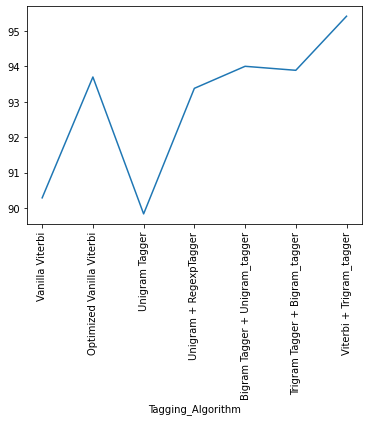

In [68]:
acccuracy_data_df.plot.line(rot = 90, legend = False)

### Check the accuracy on given Sample data

In [69]:
# sample data from Test_sentences.txt
sample_test_sentences = ['Android is a mobile operating system developed by Google.',
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [72]:
#get the word tokens of sample data
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [73]:
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]


# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]
print(sample_test_tagged_words)

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 'Twitter', "'s", 'firehose', '.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.', 'Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and',

###  1. Testing the accuracy of Vanilla Viterbi on sample test data 

In [75]:
# tagging the test sentences
sample_test_tagged_seq = Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_on_sample_test_data)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 0.7569060773480663


### 2. Testing the accuracy of Modified_Vanilla_Viterbi_for_Unknown_Words on sample test data

In [77]:
# tagging the test sentences
sample_test_unknown_word_tagged_seq = Modified_Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the Modified_Vanilla_Viterbi_for_Unknown_Words on the sample test data is -", sample_test_optimized_viterbi_accuracy)

The accuracy of the Modified_Vanilla_Viterbi_for_Unknown_Words on the sample test data is - 0.861878453038674


### 3. Testing the accuracy of viterbi_backedup_by_trigram_tagger on sample test data

In [78]:
# tagging the test sentences
sample_test_viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is -", sample_test_viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is - 0.9281767955801105


### Comparing the accuracies of the 3 algorithm on sample test data -

In [79]:
#get the all accuracy of sample data
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_viterbi_trigram_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.690608
Optimized Vanilla Viterbi,86.187845
Viterbi + Trigram_tagger,92.817680


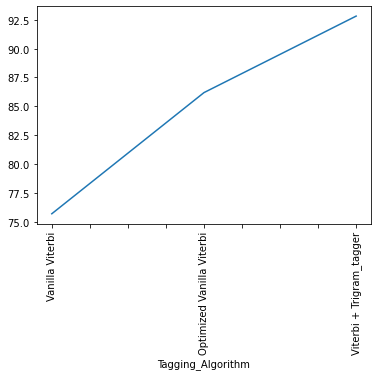

In [80]:
# Plot the accuracy of sample data
sample_test_data_acccuracy_df.plot.line(rot = 90, legend = False)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [81]:
# test sentences

test_sentence_1 = 'Android is a mobile operating system developed by Google.'
test_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
test_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_sentence_5 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
test_sentence_7 = 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'
test_sentence_9 = 'I would like to see flights from Denver to Philadelphia.'
test_sentence_10 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
test_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

## Case 1

In [82]:
# test_sentence_1 = 'Android is a mobile operating system developed by Google.'

words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Viterbi(words_test_sentence_1)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_1)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'ADV'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADV'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [83]:
#compare the vanilla_viterbi_tags vs viterbi_trigram_tags_with_corrections for sentence 1 in df
cols = ['vanilla_viterbi_tags vs ', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_1 = pd.DataFrame(columns = cols)
tags_correction_df_1 = tags_correction_df_1.fillna(0)

tags_correction_df_1.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_1.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

tags_correction_df_1

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Android, ADV)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)"
8,"(Google, ADV)","(Google, NOUN)"
9,"(., .)","(., .)"


___As we see above in the sample test sentence 1 the word 'Android', 'Google' was tagged as ADV by vanilla viterbi. The modified algorithm of viterbi backed up by trigram tagger corrected this and tagged 'Android', 'Google' as NOUN___

## Case-2

In [84]:
# test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, 
#                   an international football tournament contested once every four years.'

words_test_sentence_6 = nltk.word_tokenize(test_sentence_6)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_6 = Viterbi(words_test_sentence_6)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_6)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_6 = viterbi_backedup_by_trigram_tagger(words_test_sentence_6)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_6)


Tagging sequence with Vanilla_Viterbi -

 [('The', 'DET'), ('2018', 'ADV'), ('FIFA', 'ADV'), ('World', 'NOUN'), ('Cup', 'ADV'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'ADV'), ('FIFA', 'ADV'), ('World', 'NOUN'), ('Cup', 'ADV'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'ADV'), ('contested', 'ADV'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), 

In [85]:
#compare the vanilla_viterbi_tags vs viterbi_trigram_tags_with_corrections for sentence 6 in df
tags_correction_df_6 = pd.DataFrame(columns = cols)
tags_correction_df_6 = tags_correction_df_6.fillna(0)

tags_correction_df_6.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_6]
tags_correction_df_6.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_6]

tags_correction_df_6

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(The, DET)","(The, DET)"
1,"(2018, ADV)","(2018, NUM)"
2,"(FIFA, ADV)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)"
4,"(Cup, ADV)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)"
7,"(21st, ADV)","(21st, NUM)"
8,"(FIFA, ADV)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)"


___As we see above in the sample test sentence 6 the following words were incorrectly tagged by the vanilla viterbi algorithm - '2018', 'FIFA', 'Cup', '21st', 'tournament', 'contested'  as ADV. The above words were corrected by viterbi backed up by the trigram tagger. The corrections were made as - '2018', '21st' as *NUM, 'FIFA', 'Cup', 'tournament' as *NOUN and  'contested' as *VERB.___

## Case-3

In [86]:
# test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'

words_test_sentence_8 = nltk.word_tokenize(test_sentence_8)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_8 = Viterbi(words_test_sentence_8)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_8)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_8 = viterbi_backedup_by_trigram_tagger(words_test_sentence_8)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_8)

Tagging sequence with Vanilla_Viterbi -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'ADV'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'NOUN'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


In [87]:
#compare the vanilla_viterbi_tags vs viterbi_trigram_tags_with_corrections for sentence 8 in df
tags_correction_df_8 = pd.DataFrame(columns = cols)
tags_correction_df_8 = tags_correction_df_8.fillna(0)

tags_correction_df_8.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_8]
tags_correction_df_8.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_8]

tags_correction_df_8

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Show, NOUN)","(Show, NOUN)"
1,"(me, PRON)","(me, PRON)"
2,"(the, DET)","(the, DET)"
3,"(cheapest, ADJ)","(cheapest, ADJ)"
4,"(round, NOUN)","(round, NOUN)"
5,"(trips, ADV)","(trips, NOUN)"
6,"(from, ADP)","(from, ADP)"
7,"(Dallas, NOUN)","(Dallas, NOUN)"
8,"(to, PRT)","(to, PRT)"
9,"(Atlanta, NOUN)","(Atlanta, NOUN)"


___As we see in the sample test sentence 8, the vanilla viterbi tagged 'trips' as ADV. This was corrected by the modified viterbi algorithm (backed up by the trigram tagger) and tagged as NOUN.___

In [88]:
# Default Vanilla Viterbi
# pos tags with Vanilla_Viterbi
sample_test_tagged_sequence_with_vanilla_viterbi = Viterbi(sample_test_tagged_words)

# Method 1 - pos tags with Vanilla_Viterbi_for_Unknown_Words
sample_test_tagged_sequence_unknown_words = Modified_Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)

# Method 2 - pos tags with viterbi_backedup_by_trigram_tagger
sample_test_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)

In [89]:
# 1. the actual tags using nltk.pos_tag_sent
# 2. words as tagged by vanilla viterbi
# 3. words as tagged by Modified_Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
# 4. words as tagged by viterbi_backedup_by_trigram_tagger - METHOD - 2

cols1 = ['actual_tags', 'as_tagged_by_vanilla_viterbi', 'as_tagged_by_Vanilla_Viterbi_for_Unknown_Words',
            'as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger']

tags_comparison_df = pd.DataFrame(columns = cols1)
tags_comparison_df = tags_comparison_df.fillna(0)

# Actual tags
tags_comparison_df.actual_tags = [tup for tup in sample_test_test_run_base]

# tags by vanilla viterbi
tags_comparison_df.as_tagged_by_vanilla_viterbi = [tup for tup in sample_test_tagged_sequence_with_vanilla_viterbi]

# tags by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_for_Unknown_Words = [tup for tup in sample_test_tagged_sequence_unknown_words]

# tags by viterbi_backedup_by_trigram_tagger - METHOD - 2
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger = [tup for tup in 
                                                                            sample_test_tagged_sequence_with_viterbi_trigram]

tags_comparison_df[tags_comparison_df.as_tagged_by_vanilla_viterbi != 
                   tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger]

,actual_tags,as_tagged_by_vanilla_viterbi,as_tagged_by_Vanilla_Viterbi_for_Unknown_Words,as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger
0,"(Android, NOUN)","(Android, ADV)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, ADV)","(Google, DET)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, ADV)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, ADV)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, ADV)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, ADV)","(smartphones, DET)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, ADV)","(2011, DET)","(2011, NUM)"
25,"(2013, NUM)","(2013, ADV)","(2013, DET)","(2013, NUM)"
27,"(Google, NOUN)","(Google, ADV)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, ADV)","(Twitter, NOUN)","(Twitter, NOUN)"


### Conclusion 
Thus we see that most of the words that were incorrectly tagged by the vanilla viterbi algorithm were corrected by the viterbi algorithm backed up by the trigram tagger.
In this analysis we used 2 modification techniques for the original vanilla viterbi -

__Method 1 -__
- We used only the transition probability for unknown words.
- This method showed an increase in the accuracy (94.4%) but still had some incorrect classification.

- The accuracy could be increased further and we turned two a second modification in method-2 below.

__Method 2 -__
- We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based 
regex tagger.
- This gave us an accuracy of 95.82% on the test data.
- Also on testing this model on the provided sample test data, it achieved an accuracy of 92.81% and comes out to be 
the winner.